<a href="https://colab.research.google.com/github/keerthireddy-28/GenerativeAI/blob/main/GenAI_CourseProject_Team8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Image Colorization**

# **1.Downloading and Processing the data**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/img_color_data.zip

Streaming output truncated to the last 5000 lines.
  inflating: landscape Images/gray/2914.jpg  
  inflating: landscape Images/gray/2915.jpg  
  inflating: landscape Images/gray/2916.jpg  
  inflating: landscape Images/gray/2917.jpg  
  inflating: landscape Images/gray/2918.jpg  
  inflating: landscape Images/gray/2919.jpg  
  inflating: landscape Images/gray/292.jpg  
  inflating: landscape Images/gray/2920.jpg  
  inflating: landscape Images/gray/2921.jpg  
  inflating: landscape Images/gray/2922.jpg  
  inflating: landscape Images/gray/2923.jpg  
  inflating: landscape Images/gray/2924.jpg  
  inflating: landscape Images/gray/2925.jpg  
  inflating: landscape Images/gray/2926.jpg  
  inflating: landscape Images/gray/2927.jpg  
  inflating: landscape Images/gray/2928.jpg  
  inflating: landscape Images/gray/2929.jpg  
  inflating: landscape Images/gray/293.jpg  
  inflating: landscape Images/gray/2930.jpg  
  inflating: landscape Images/gray/2931.jpg  
  inflating: landscape Images/g

In [3]:
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import os


batch_size = 64
img_size = 120
dataset_split = 2500

# Paths to grayscale and color images
gray_dir = '/content/landscape Images/gray'
color_dir = '/content/landscape Images/color'

# Prepare data
x = []
y = []

# Get the list of filenames common to both folders
image_filenames = sorted(os.listdir(gray_dir))[:dataset_split]

for filename in image_filenames:
    gray_path = os.path.join(gray_dir, filename)
    color_path = os.path.join(color_dir, filename)

    # Ensure both files exist
    if os.path.exists(gray_path) and os.path.exists(color_path):
        # Load and resize color image
        color_image = Image.open(color_path).resize((img_size, img_size)).convert('RGB')
        rgb_img_array = np.asarray(color_image) / 255.0

        # Load and resize grayscale image
        gray_image = Image.open(gray_path).resize((img_size, img_size)).convert('L')
        gray_img_array = np.asarray(gray_image).reshape((img_size, img_size, 1)) / 255.0

        # Add to datasets
        x.append(gray_img_array)
        y.append(rgb_img_array)

# Convert to numpy arrays
x = np.array(x)
y = np.array(y)

# Train-test split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.1, random_state=42)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y))
dataset = dataset.batch(batch_size)


# **2.Model**

In [4]:
def get_generator_model():

    inputs = tf.keras.layers.Input( shape=( img_size , img_size , 1 ) )

    conv1 = tf.keras.layers.Conv2D( 16 , kernel_size=( 5 , 5 ) , strides=1 )( inputs )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )
    conv1 = tf.keras.layers.Conv2D( 32 , kernel_size=( 3 , 3 ) , strides=1)( conv1 )
    conv1 = tf.keras.layers.LeakyReLU()( conv1 )

    conv2 = tf.keras.layers.Conv2D( 32 , kernel_size=( 5 , 5 ) , strides=1)( conv1 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )
    conv2 = tf.keras.layers.Conv2D( 64 , kernel_size=( 3 , 3 ) , strides=1 )( conv2 )
    conv2 = tf.keras.layers.LeakyReLU()( conv2 )

    conv3 = tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1 )( conv2 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )
    conv3 = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 )( conv3 )
    conv3 = tf.keras.layers.LeakyReLU()( conv3 )

    bottleneck = tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='tanh' , padding='same' )( conv3 )

    concat_1 = tf.keras.layers.Concatenate()( [ bottleneck , conv3 ] )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_1 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 128 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_3 )
    conv_up_3 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_3 )

    concat_2 = tf.keras.layers.Concatenate()( [ conv_up_3 , conv2 ] )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( concat_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 64 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' )( conv_up_2 )
    conv_up_2 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu' )( conv_up_2 )

    concat_3 = tf.keras.layers.Concatenate()( [ conv_up_2 , conv1 ] )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( concat_3 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 32 , kernel_size=( 3 , 3 ) , strides=1 , activation='relu')( conv_up_1 )
    conv_up_1 = tf.keras.layers.Conv2DTranspose( 3 , kernel_size=( 5 , 5 ) , strides=1 , activation='relu')( conv_up_1 )

    model = tf.keras.models.Model( inputs , conv_up_1 )
    return model


In [5]:
def get_discriminator_model():
    layers = [
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7 , 7 ) , strides=1 , activation='relu' , input_shape=( 120 , 120 , 3 ) ),
        tf.keras.layers.Conv2D( 32 , kernel_size=( 7, 7 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 64 , kernel_size=( 5 , 5 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 128 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.Conv2D( 256 , kernel_size=( 3 , 3 ) , strides=1, activation='relu'  ),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense( 512, activation='relu'  )  ,
        tf.keras.layers.Dense( 128 , activation='relu' ) ,
        tf.keras.layers.Dense( 16 , activation='relu' ) ,
        tf.keras.layers.Dense( 1 , activation='sigmoid' )
    ]
    model = tf.keras.models.Sequential( layers )
    return model


# **Loss Functions**

In [6]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output) - tf.random.uniform( shape=real_output.shape , maxval=0.1 ) , real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output) + tf.random.uniform( shape=fake_output.shape , maxval=0.1  ) , fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output , real_y):
    real_y = tf.cast( real_y , 'float32' )
    return mse( fake_output , real_y )

generator_optimizer = tf.keras.optimizers.Adam( 0.0005 )
discriminator_optimizer = tf.keras.optimizers.Adam( 0.0005 )

generator = get_generator_model()
discriminator = get_discriminator_model()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **3.Training The Model**

In [7]:
@tf.function
def train_step( input_x , real_y ):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate an image -> G( x )
        generated_images = generator( input_x , training=True)
        # Probability that the given image is real -> D( x )
        real_output = discriminator( real_y, training=True)
        # Probability that the given image is the one generated -> D( G( x ) )
        generated_output = discriminator(generated_images, training=True)

        # L2 Loss -> || y - G(x) ||^2
        gen_loss = generator_loss( generated_images , real_y )
        # Log loss for the discriminator
        disc_loss = discriminator_loss( real_output, generated_output )

    #tf.keras.backend.print_tensor( tf.keras.backend.mean( gen_loss ) )
    #tf.keras.backend.print_tensor( gen_loss + disc_loss )

    # Compute the gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Optimize with Adam
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [8]:
num_epochs = 150

for e in range( num_epochs ):
    print( e )
    for ( x , y ) in dataset:
        # Here ( x , y ) represents a batch from our training dataset.
        print( x.shape )
        train_step( x , y )



0
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(10, 120, 120, 1)
1
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 120, 120, 1)
(64, 1

KeyboardInterrupt: 

# **4.Results**

In [17]:
y = generator.predict(test_x, batch_size=16)


16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 457ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


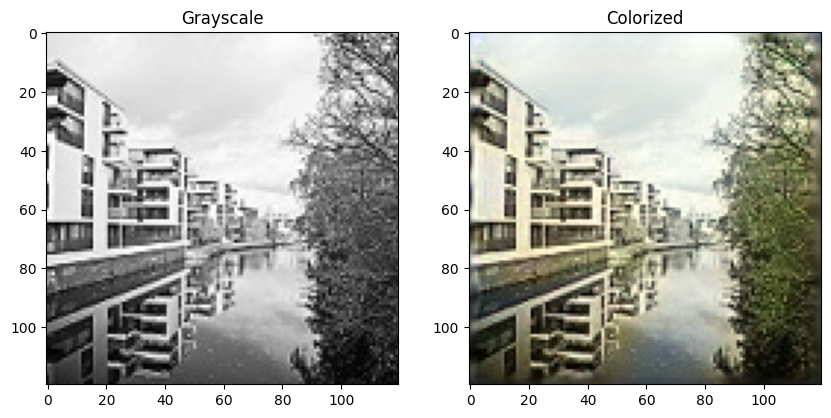

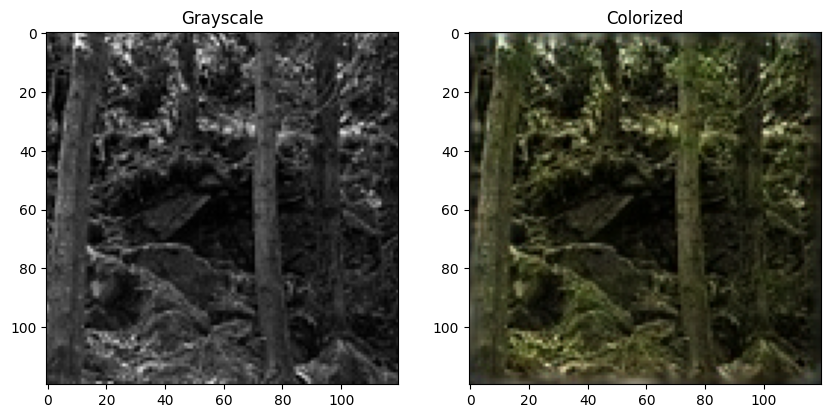

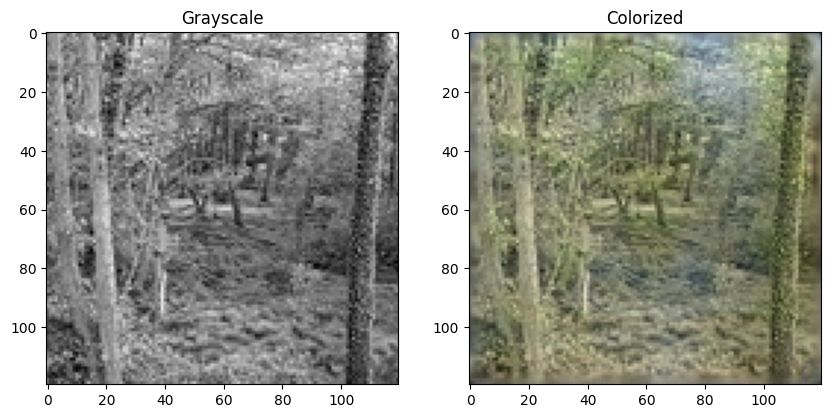

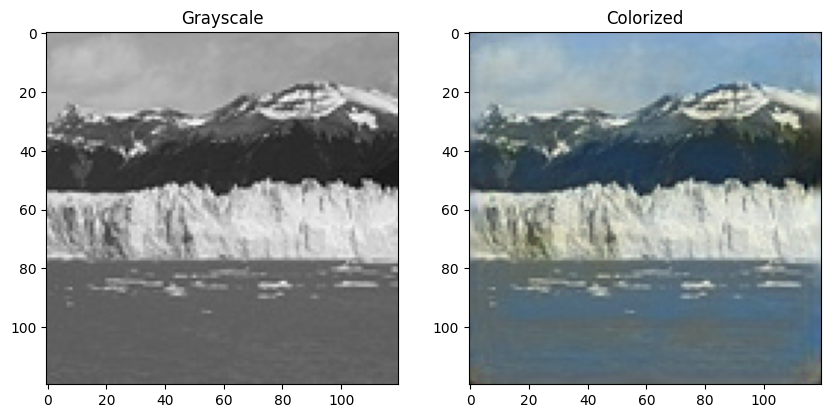

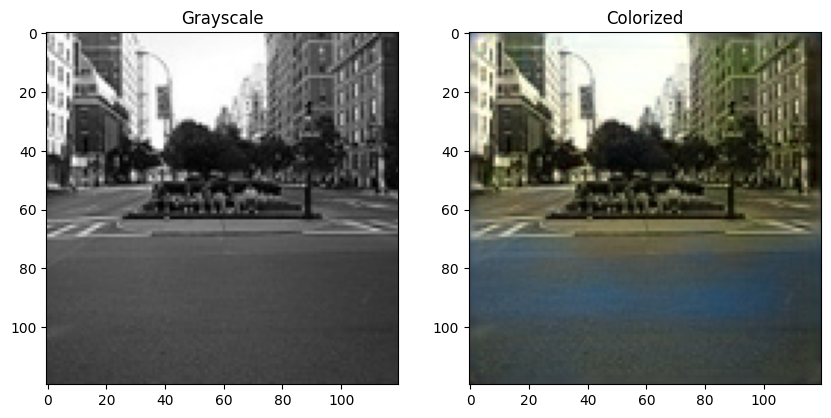

In [20]:
# Generate colorized images for a few test samples
test_images = test_x[:5]  # Take a few test images
colorized_images = generator.predict(test_images)

# Display the grayscale input and colorized output side by side
import matplotlib.pyplot as plt

for i in range(len(test_images)):
    plt.figure(figsize=(10, 5))

    # Grayscale input
    plt.subplot(1, 2, 1)
    plt.title("Grayscale")
    plt.imshow(test_images[i].reshape((img_size, img_size)), cmap='gray')

    # Colorized output
    plt.subplot(1, 2, 2)
    plt.title("Colorized")
    plt.imshow(colorized_images[i])

    plt.show()
